## Classical NDWT of Doppler512 (Haar, 4 Levels, 16 Shifts)

This code computes a **purely classical** nondecimated Haar wavelet transform (NDWT) of the Doppler512 signal using the standard *shift–sum construction*.  
Although conceptually aligned with the **QNDWT**, everything here is classical—no Qiskit or quantum gates are used.

### Overview

- Signal length:  
  $$N = 512.$$

- Number of circular shifts ($L$ is the depth of transform):  
  $$2^L = 16 \quad (L=4).$$  

- For each shift $\varepsilon = 0,\dots,15$:
  1. Circularly shift the signal:  
     $$x_\varepsilon[n] = x[(n-\varepsilon) \bmod N].$$
  2. Compute the **4-level orthogonal Haar DWT**:
     $$a_4^{(\varepsilon)},\ d_1^{(\varepsilon)}, d_2^{(\varepsilon)}, d_3^{(\varepsilon)}, d_4^{(\varepsilon)}.$$

- Assemble the **nondecimated wavelet sequences**:
  $$w_j[n] = \frac{1}{\sqrt{2^j}} 
      \sum_{\varepsilon=0}^{15}
      \text{place\_and\_unshift}\bigl(d_j^{(\varepsilon)}\bigr), \qquad j=1,\dots,4,$$

  and similarly for the approximation:
  $$a_4[n] = \frac{1}{\sqrt{16}}
      \sum_{\varepsilon=0}^{15}
      \text{place\_and\_unshift}\bigl(a_4^{(\varepsilon)}\bigr).$$

### Output

The stacked matrix contains **full-length (512-point)** NDWT coefficients at four scales.  
The plot produced by:


plt.imshow(np.abs(Wmat), aspect='auto', origin='lower')

shows the familiar NDWT structure:

Bottom row: coarse approximation $a_4$

Top row: finest details $w_1$

This example serves as a classical baseline for the quantum NDWT (QNDWT).
It uses the exact same logic—circular shifts + orthogonal Haar + placement/unshifting—
but does so without quantum circuits, making the structure easy to inspect and validate.

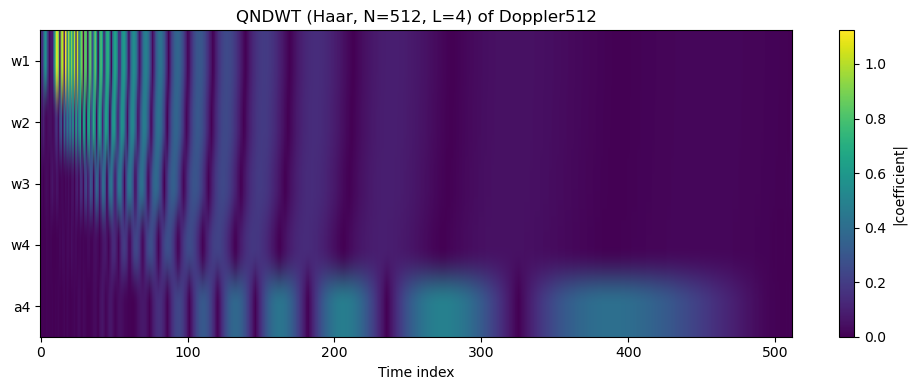

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# -------------------------
# 1) Doppler signal (N=512)
# -------------------------
N = 512
t = np.linspace(0, 1, N)
Doppler512 = np.sqrt(t * (1 - t)) * np.sin((2 * np.pi * 1.05) / (t + 0.05))

# -------------------------
# 2) Haar multilevel DWT
# -------------------------
def haar_level_mats(n):
    half = n // 2
    A = np.zeros((half, n), dtype=float)
    D = np.zeros((half, n), dtype=float)
    inv = 1.0 / sqrt(2.0)
    for k in range(half):
        i0, i1 = 2*k, 2*k+1
        A[k, i0] = inv; A[k, i1] = inv
        D[k, i0] = inv; D[k, i1] = -inv
    return A, D

def haar_dwt_multilevel(x, J):
    """
    J-level orthogonal Haar DWT of vector x (length N=2^n).
    Returns: a_J, details dict mapping j -> d_j (length N/2^j).
    Coefficient ordering is NOT assembled here; we just keep pieces.
    """
    N = x.size
    a = x.copy()
    n_curr = N
    details = {}
    for j in range(1, J+1):
        A, D = haar_level_mats(n_curr)
        a_new = A @ a[:n_curr]
        d_new = D @ a[:n_curr]
        details[j] = d_new
        a[:n_curr//2] = a_new
        n_curr //= 2
    a_J = a[:n_curr]
    return a_J, details

def place_and_unshift(vec_dec, stride, N, eps):
    """
    Place decimated vector on indices {0, stride, 2*stride, ...},
    then circularly unshift by eps.
    """
    out = np.zeros(N, dtype=float)
    k = 0
    for n in range(0, N, stride):
        out[n] = vec_dec[k]
        k += 1
    return np.roll(out, -eps)

# -------------------------
# 3) QNDWT parameters
# -------------------------
J = 4          # levels
L = 4          # ancilla bits => 2^L = 16 shifts
shifts = range(2**L)  # eps = 0..15

# Per-shift Haar coefficients
a4_eps = {}
d_eps = {j: {} for j in range(1, J+1)}

for eps in shifts:
    x_eps = np.roll(Doppler512, eps)
    a4, details = haar_dwt_multilevel(x_eps, J)
    a4_eps[eps] = a4
    for j in range(1, J+1):
        d_eps[j][eps] = details[j]

# -------------------------
# 4) Assemble QNDWT w1..w4, a4 (length N each)
# -------------------------
w = {j: np.zeros(N, dtype=float) for j in range(1, J+1)}
a4_full = np.zeros(N, dtype=float)

for eps in shifts:
    for j in range(1, J+1):
        stride = 2**j
        # 2^{-j/2} scaling for NDWT-style normalization
        w[j] += place_and_unshift(d_eps[j][eps], stride, N, eps) / np.sqrt(2**j)
    a4_full += place_and_unshift(a4_eps[eps], 2**J, N, eps) / np.sqrt(2**J)

w1, w2, w3, w4 = w[1], w[2], w[3], w[4]

# -------------------------
# 5) Stack and plot as matrix
# -------------------------
Wmat = np.vstack([a4_full, w4, w3, w2, w1])   # shape (5, 512)

plt.figure(figsize=(10, 4))
plt.imshow(np.abs(Wmat), aspect='auto', origin='lower')
plt.colorbar(label='|coefficient|')
plt.yticks(range(5), ['a4', 'w4', 'w3', 'w2', 'w1'])
plt.xlabel('Time index')
plt.title('QNDWT (Haar, N=512, L=4) of Doppler512')
plt.tight_layout()
plt.show()
